In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [53]:
# build the vocabulary of caracters and mappings to/from intergers  
words = open('names.txt','r').read().splitlines()

chars = sorted(set("".join(words)))
stoi  = {s:i for i,s in enumerate(chars, start=1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [54]:
# split the dataset to "training", "validation" and "test"


# build the dataset 
block_size = 3  # context length, we take 'e','m','m' to predict 'a'

def build_dataset(words):
    X,Y = [],[]

    for w in words: 
        context = [0] * block_size # pre-pend empty char
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [56]:
g = torch.Generator().manual_seed(2147483647)

n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd),             generator=g)    # one char to 2 features, feature layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  # hidden layer
b1 = torch.randn(n_hidden,                        generator=g)    
W2 = torch.randn((n_hidden, vocab_size),          generator=g)# output layer
b2 = torch.randn(vocab_size,                      generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))  # total number of parameters


for p in parameters:
    p.requires_grad = True

11897


In [57]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y
    
    # forward pass
    emb = C[Xb]  # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # backward 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.item())

      0/ 200000: 27.8817
  10000/ 200000: 2.6480
  20000/ 200000: 2.5211
  30000/ 200000: 2.8322
  40000/ 200000: 2.1849
  50000/ 200000: 2.5281
  60000/ 200000: 2.4177
  70000/ 200000: 2.0097
  80000/ 200000: 2.2562
  90000/ 200000: 2.1336
 100000/ 200000: 2.0161
 110000/ 200000: 2.4205
 120000/ 200000: 1.8736
 130000/ 200000: 2.3686
 140000/ 200000: 2.2255
 150000/ 200000: 2.1092
 160000/ 200000: 1.9994
 170000/ 200000: 1.7841
 180000/ 200000: 1.9813
 190000/ 200000: 1.7708


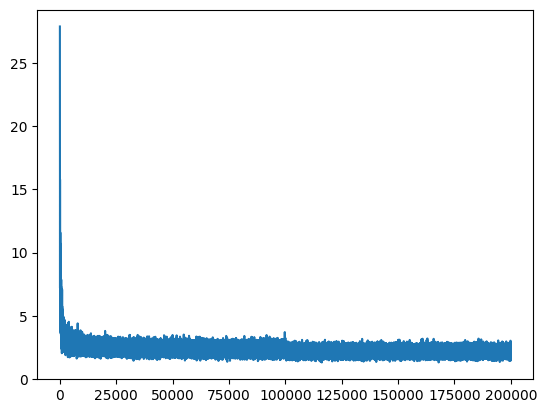

In [58]:
plt.plot(lossi)

In [73]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.124398946762085
val 2.1663334369659424


In [74]:
# sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True: 
        # forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item();
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break;
    print(''.join(itos[i] for i in out))

osz.
harihalara.
avean.
dulla.
wadeanstayton.
shel.
dur.
wavia.
sardon.
kashloett.
mackylberklyn.
jagm.
ajaov.
kashamsyra.
abbeoten.
hadlisen.
colla.
samena.
kai.
angelnessirie.


In [75]:
# pytorchify the above code to modules

In [114]:
class Linear: 

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        # buffers (trained with a running momemtum update)
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar   = x.var(0, keepdim=True)
        else:
            xmeam = self.running_mean
            xvar  = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out 
    
    def parameters(self):
            return [self.gamma, self.beta]
        
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [115]:
g = torch.Generator().manual_seed(2147483647)

n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1   # last layer: make less confident
    for layer in layers[:-1]:  # all other layers : apply gain
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # total number of parameters
for p in parameters:
    p.requires_grad=True

47497


In [116]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y
    
    # forward pass
    emb = C[Xb]  # (32, 3, 2)
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward 
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    


      0/ 200000: 3.2869
  10000/ 200000: 2.3536
  20000/ 200000: 2.0481
  30000/ 200000: 1.9798
  40000/ 200000: 2.1022
  50000/ 200000: 2.3221
  60000/ 200000: 1.8259
  70000/ 200000: 2.2275
  80000/ 200000: 2.2852
  90000/ 200000: 1.8405
 100000/ 200000: 2.4169
 110000/ 200000: 2.1714
 120000/ 200000: 2.0479
 130000/ 200000: 2.0398
 140000/ 200000: 1.7486


KeyboardInterrupt: 